### I. Commentaire de l'article "The Cointegration Alpha: Enhanced Index Tracking and Long-Short Equity Market Neutral Strategies"

Cet article propose différentes applications de stratégies d'investissement basées sur la cointégration, on note : 

- une stratégie classique de suivi d'indices;
- une stratégie d'actions long-short market neutral;
- une combinaison des deux approches précédentes.

L'idée de la première stratégie est de reproduire les rendements et la volatilité d'un indice de référence spécifique (exemple du CAC40), c'est-à-dire un portefeuille ayant de propriétés similaires à celui de l'indice en termes de rendements, volatilité et corrélation; tandis que les deux stratégies suivantes visent à minimiser la volatilité et générer des rendements stables quelles que soient les conditions de marché.

L'avantage de se baser sur la cointégration pour l'optimisation de portefeuille est qu'elle permet d'utiliser toutes les informations comprises dans les prix et de construire des poids sur le comportement long terme des actions.

One of the advantages of estimating the portfolio weights based on cointegration coefficients is their
enhanced stability. Being constructed on a rather long history of prices, they tend to ignore short-term
movements in stock prices, such as bubbles or just noise, and focus on the long-run behaviour of the
prices. 

The main point of our analysis was to show that, when applied to constructing trading strategies, the
cointegration technique produces encouraging results. Its key characteristics, i.e. mean reverting
tracking error, enhanced weights stability and better use of the information contained in stock prices,
allow a flexible design of various trading strategies, from index tracking to long-short market neutral.

## II. Expériences numériques transposées au marché français.

### 0. Data 

On pré-processe ici les données du CAC40 de 2001 à nos jours. Pour certaines valeurs, les données sont manquantes à partir d'un certain rang, on les complète naïvement par la dernière valeur présente dans cette colonne.

In [1]:
import pandas as pd
import numpy as np
from utils_long_short import calculer_rendement_iteratif, perform_regression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

In [2]:
file_path = '../data/CAC.xlsx'
sheet_name_weights = 'Worksheet'
sheet_name_data = 'Data'

df_weights = pd.read_excel(file_path, sheet_name=sheet_name_weights, index_col=0)
dict_weights_CAC = df_weights['Poids'].to_dict()

df_data = pd.read_excel(file_path, sheet_name=sheet_name_data, index_col=0)
df_data = df_data.fillna(method='ffill')

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_13019/1987031244.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_data = df_data.fillna(method='ffill')


In [3]:
dict_weights_CAC

{'AI FP Equity': 0.0534,
 'AIR FP Equity': 0.0476,
 'ALO FP Equity': 0.0022,
 'MT NA Equity': 0.0077,
 'CS FP Equity': 0.0327,
 'BNP FP Equity': 0.0426,
 'EN FP Equity': 0.0038,
 'CAP FP Equity': 0.0182,
 'CA FP Equity': 0.0055,
 'SGO FP Equity': 0.0178,
 'ML FP Equity': 0.0133,
 'ACA FP Equity': 0.0079,
 'BN FP Equity': 0.0217,
 'DSY FP Equity': 0.0173,
 'EDEN FP Equity': 0.0078,
 'ENGI FP Equity': 0.017,
 'EL FP Equity': 0.0332,
 'ERF FP Equity': 0.0043,
 'RMS FP Equity': 0.0352,
 'KER FP Equity': 0.0173,
 'OR FP Equity': 0.0619,
 'LR FP Equity': 0.0146,
 'MC FP Equity': 0.1064,
 'ORA FP Equity': 0.0111,
 'RI FP Equity': 0.019,
 'PUB FP Equity': 0.0112,
 'RNO FP Equity': 0.0045,
 'SAF FP Equity': 0.0335,
 'SAN FP Equity': 0.0585,
 'SU FP Equity': 0.0601,
 'GLE FP Equity': 0.0104,
 'STLAP FP Equity': 0.029,
 'STMPA FP Equity': 0.0168,
 'TEP FP Equity': 0.0046,
 'HO FP Equity': 0.0081,
 'TTE FP Equity': 0.09,
 'URW FP Equity': 0.0046,
 'VIE FP Equity': 0.0101,
 'DG FP Equity': 0.0351,


In [4]:
df_data.columns

Index(['CAC Index', 'OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
       'TTE FP Equity', 'DSY FP Equity', 'AI FP Equity', 'ERF FP Equity',
       'CS FP Equity', 'BNP FP Equity', 'BN FP Equity', 'SGO FP Equity',
       'MC FP Equity', 'EDEN FP Equity', 'ML FP Equity', 'KER FP Equity',
       'PUB FP Equity', 'RNO FP Equity', 'SAF FP Equity', 'HO FP Equity',
       'TEP FP Equity', 'RMS FP Equity', 'ENGI FP Equity', 'ORA FP Equity',
       'MT NA Equity', 'EN FP Equity', 'ALO FP Equity', 'VIE FP Equity',
       'SAN FP Equity', 'GLE FP Equity', 'SU FP Equity', 'AIR FP Equity',
       'URW FP Equity', 'LR FP Equity', 'ACA FP Equity', 'RI FP Equity',
       'STMPA FP Equity'],
      dtype='object')

# Long short Market neutral strategy 

On ajoute au benchmark en rendement supplémentaire de x% distrbué uniformément sur les jours. On va prendre x valant 5%, 10% et 15%. On le retire et on l'ajoute pour contruire un 'index_plus' et un 'index_minus'. 

### Création d'un index_plus et d'un index_minus

La fonction calculer rendement iteratif permet de d'ajouter un pourcentage au rendement du cac40. 

In [3]:
data = df_data[['CAC Index','ACA FP Equity','OR FP Equity', 'DG FP Equity', 'STLAP FP Equity',
       'TTE FP Equity']] #on choisit de travailler sur uniquement quelques valeurs  

In [4]:
df_plus_5_5y = calculer_rendement_iteratif(data, '2018-01-03', 5) #dataframe, date_depart, augmentation par an en pourcentage
df_min_5_5y = calculer_rendement_iteratif(data, '2018-01-03', -5)


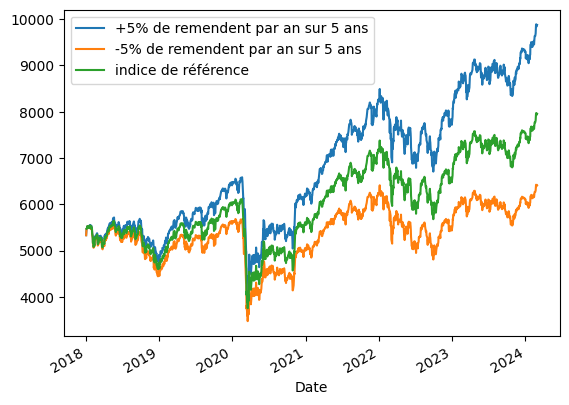

In [5]:
df_plus_5_5y["CAC Index Ajusté"].plot(label="+5% de remendent par an sur 5 ans")
df_min_5_5y["CAC Index Ajusté"].plot(label="-5% de remendent par an sur 5 ans")
df_data.loc["2018-01-05 ":]["CAC Index"].plot(label="indice de référence")
plt.legend()
plt.show() 

La nouvelle cointegration décrite dans l'article s'écrit de la manière suivante:

In [6]:
params_plus_intercept, params_plus, residuals_plus = perform_regression(df_plus_5_5y)
params_moins_intercept, params_moins, residuals_moins = perform_regression(df_min_5_5y)
print('les paramètres fit sont pour l\'index_plus: \n',params_plus)

print('les paramètres fit sont pour l\'index_moins: \n',params_moins)



les paramètres fit sont pour l'index_plus: 
 ACA FP Equity     -0.003934
OR FP Equity       0.574702
DG FP Equity       0.244843
STLAP FP Equity    1.028511
TTE FP Equity      0.299808
dtype: float64
les paramètres fit sont pour l'index_moins: 
 ACA FP Equity     -0.130361
OR FP Equity       0.148804
DG FP Equity       0.295488
STLAP FP Equity    1.869585
TTE FP Equity      0.195141
dtype: float64


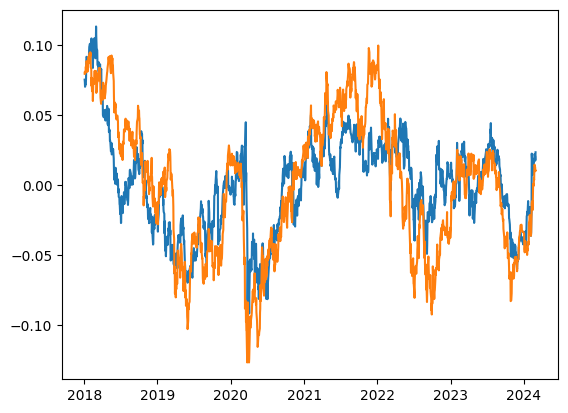

In [7]:
plt.plot(residuals_plus)
plt.plot(residuals_moins)

### Backtest de la stratégie. 
On va ici ré-éstimer tous les 10 jours nos poids sur la période [date départ, date précédente+10]. On va à chaque fois que l'on rebalance nos poids s'assurer que le test ADF est correct, i.e. que la cointégration fonctionne proprement, et nous allons plotter ce graphique. On va aussi calculer le prix que l'on obtient en soustrayant les couts. Cela nous permettra d'avoir un rendement en temps réel de notre stratégie, vs un rendement de l'indice. Le fait d'avoir le prix en continu devrait nous permettre aussi d'avoir la volatilité, la possibilité de calculer la skewness et la kurtosis, ainsi que les sharpe ratio. 

In [16]:
df_plus_5_5y.iloc[-1].name

Timestamp('2024-02-28 00:00:00')

In [55]:
def rebalance_and_evaluate(df_plus, df_minus, start_date, costs):
    # Convertir start_date en objet datetime si nécessaire
    current_date = pd.to_datetime(start_date)+ pd.DateOffset(days=10)

    end_date = df_plus.iloc[-1].name # Supposons que l'index du df est une série de dates


    # Initialiser la liste pour stocker les résultat
    prices_list = []
    adf_stats_list = []
    portfolio = pd.DataFrame()
    replication_max = pd.DataFrame()
    replication_min = pd.DataFrame()
    params_plus_old =perform_regression(df_plus)[2]
    params_minus_old =  perform_regression(df_minus)[2]
    
    while current_date < end_date:
        # Sélectionner la tranche de données jusqu'à la date courante
        data_slice_plus = df_plus.loc[start_date:current_date]
        data_slice_minus = df_minus.loc[start_date:current_date]
        

        intercept_plus, params_plus, residuals_plus = perform_regression(data_slice_plus)
        intercept_minus, params_minus, residuals_minus = perform_regression(data_slice_minus)
        #print(np.sum(abs((params_plus-params_minus) - (params_plus_old-params_minus_old))*data_slice_plus.iloc[-1,1:-1]))
        #print("ok")

        costs = 0.002*np.sum(abs((params_plus-params_minus) - (params_plus_old-params_minus_old))*data_slice_plus.iloc[-1,1:-1])

 

        params_plus_old = params_plus
        params_minus_old = params_minus
        
        

        
        # Effectuer le test ADF sur les résidus
        adf_result = adfuller(residuals_plus)
        adf_stats_list.append(adf_result[0])
        
        # Vérifier les valeurs critiques pour la cointégration
        #if adf_result[0] > adf_result[4]['1%']:  # Si la stat est plus grande que la valeur critique à 1%
            # Ne pas procéder au rebalancement si la cointégration n'est pas présente
           
           # break
        data_plus = df_plus.loc[current_date-pd.DateOffset(days=10):current_date]
        data_moins = df_minus.loc[current_date-pd.DateOffset(days=10):current_date]
       
        # Calculer le prix du portfolio après soustraction des coûts
        portfolio_price_plus = np.exp(np.sum(params_plus * np.log(data_plus.iloc[:, 1:-1]),axis=1)) - costs/2 #le prix de notre portefeuille, il manque les dates uniquement
        portfolio_price_minus= np.exp(np.sum(params_minus * np.log(data_moins.iloc[:, 1:-1]),axis=1)) - costs/2 #le prix de notre portefeuille, il manque les dates uniquement


        prices_list.append(portfolio_price_plus-portfolio_price_minus)
        portfolio = pd.concat([portfolio, portfolio_price_plus-portfolio_price_minus])
        replication_max = pd.concat([replication_max, portfolio_price_plus])
        replication_min = pd.concat([replication_min,portfolio_price_minus ])

     
        current_date += pd.DateOffset(days=10) #on modifie la date.. 
    
  
    return  adf_stats_list,replication_max,replication_min

# Cette fonction est un pseudo-code et doit être ajustée en fonction des spécificités de vos données.
adf_stats_list,replication_max,replication_min = rebalance_and_evaluate(df_plus_5_5y,df_min_5_5y,'2018-01-03',1)


/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_13019/1171297862.py:56: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolio = pd.concat([portfolio, portfolio_price_plus-portfolio_price_minus])
/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_13019/1171297862.py:57: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  replication_max = pd.concat([replication_max, portfolio_price_plus])
/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_13019/1171297862.py:58: FutureWarning: The behavior of array concatenation with empty entries i

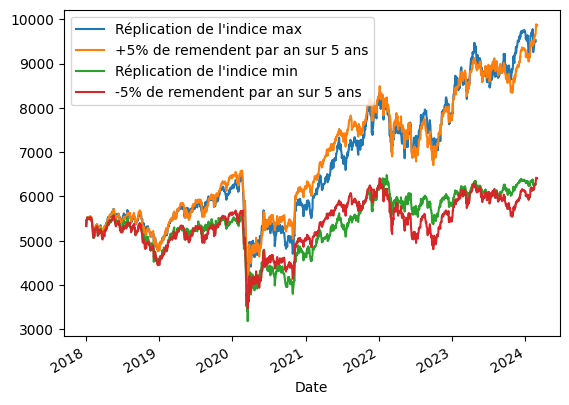

In [59]:
plt.plot(replication_max,label="Réplication de l'indice max")
df_plus_5_5y["CAC Index Ajusté"].plot(label="+5% de remendent par an sur 5 ans")

plt.plot(replication_min,label="Réplication de l'indice min")
df_min_5_5y["CAC Index Ajusté"].plot(label="-5% de remendent par an sur 5 ans")

plt.legend()
plt.show() 

<Axes: >

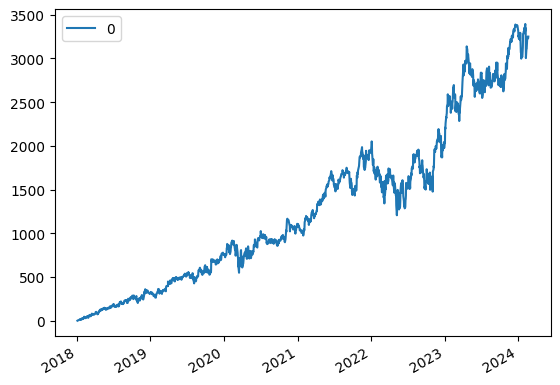

In [61]:
prices_df.plot()

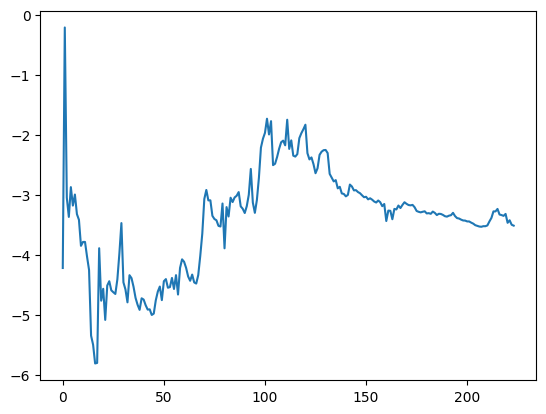

In [60]:
plt.plot(adf_stats_list)

In [46]:
from statsmodels.tsa.stattools import adfuller

# The function to perform the Augmented Dickey-Fuller test and plot the statistic
def plot_adf_test(residuals):
    """
    This function performs the Augmented Dickey-Fuller test on the residuals and plots the
    test statistic along with the critical value thresholds.
    """
    # Perform ADF test
    result = adfuller(residuals)
    
    # Extract the ADF statistic and the critical values
    adf_stat = result[0] # la stat 
    crit_values = result[4]
    
    # Prepare the plot
    plt.figure(figsize=(10, 5))
    plt.plot(residuals.index, [adf_stat]*len(residuals), label='ADF Statistic')
    
    # Plot critical values
    for key, value in crit_values.items():
        plt.hlines(y=value, xmin=residuals.index[0], xmax=residuals.index[-1], colors='r', linestyles='dashed', label=f'Critical Value ({key})')
    
    plt.title('ADF Statistic vs Critical Values')
    plt.legend()
    plt.show()
    
    return result

# This function assumes that 'residuals' is a pandas Series with a datetime index.
# Since this is an example, the actual 'residuals' should be provided by the user to run this function.

# The user should call this function with the actual residuals as follows:
# adf_result = plot_adf_test(residuals)

# Mock output
'Function ready to be used with the actual residuals for ADF test plotting.'


'Function ready to be used with the actual residuals for ADF test plotting.'

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_11333/2397600064.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='1/1/2000', periods=100, freq='M')


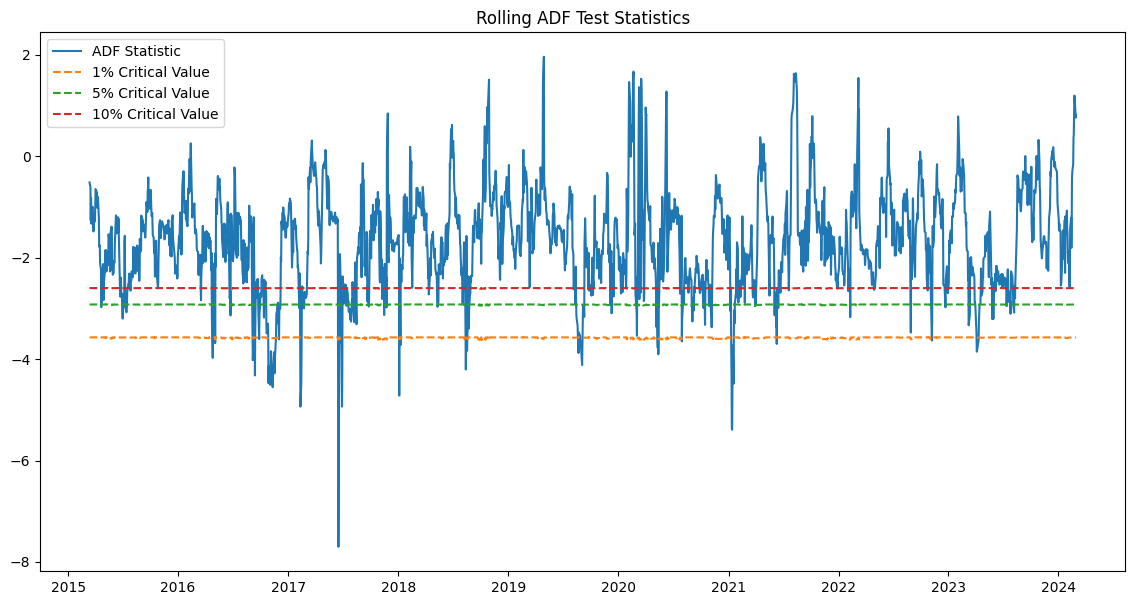

,ADF Statistic,1% Critical Value,5% Critical Value,10% Critical Value
Date,,,,
2015-03-13,-0.516256,-3.571472,-2.922629,-2.599336
2015-03-16,-0.606241,-3.571472,-2.922629,-2.599336
2015-03-17,-1.263322,-3.571472,-2.922629,-2.599336
2015-03-18,-0.819947,-3.571472,-2.922629,-2.599336
2015-03-19,-1.329122,-3.571472,-2.922629,-2.599336


In [45]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'residuals' is a pandas Series with a datetime index and has the residuals from the regression
# For demonstration, let's create a mock series of residuals
np.random.seed(0)  # For reproducibility
dates = pd.date_range(start='1/1/2000', periods=100, freq='M')
mock_residuals = pd.Series(np.random.randn(100), index=dates)

def rolling_adf_test(series, window_size):
    """
    Perform a rolling Augmented Dickey-Fuller test on a series.

    :param series: Pandas Series with datetime index
    :param window_size: integer, size of the rolling window
    :return: DataFrame with ADF statistic and critical values for each window
    """
    # Store rolling ADF results
    rolling_adf_stats = []
    rolling_critical_values = {'1%': [], '5%': [], '10%': []}
    
    # Perform rolling ADF test
    for start in range(len(series) - window_size + 1):
        # Create a rolling window
        window = series.iloc[start:start + window_size]
        # Perform ADF test on this window
        adf_result = adfuller(window)
        rolling_adf_stats.append(adf_result[0])
        for key in rolling_critical_values.keys():
            rolling_critical_values[key].append(adf_result[4][key])
    
    # Prepare DataFrame for plotting
    rolling_adf_df = pd.DataFrame(index=series.index[window_size-1:])
    rolling_adf_df['ADF Statistic'] = rolling_adf_stats
    for key, value in rolling_critical_values.items():
        rolling_adf_df[f'{key} Critical Value'] = value
    
    return rolling_adf_df

# Define a window size
window_size = 50  # 5 years in months

# Perform rolling ADF test
rolling_adf_results = rolling_adf_test(residuals_moins, window_size)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(rolling_adf_results['ADF Statistic'], label='ADF Statistic')

# Plot critical values
for key in ['1%', '5%', '10%']:
    plt.plot(rolling_adf_results.index, rolling_adf_results[f'{key} Critical Value'], label=f'{key} Critical Value', linestyle='--')

plt.title('Rolling ADF Test Statistics')
plt.legend()
plt.show()

# Returning the first few rows of the results for inspection
rolling_adf_results.head()
